## 12. Matplotlib overview

We give a top-down overview of the Matplotlib library and its capabilities.


## Plotting in two dimensions with matplotlib.

A useful resource for the basics of matplotlib is the [matplotlib FAQ "General Concepts" section](https://matplotlib.org/faq/usage_faq.html).  It outlines the primary structures and terminology used by matplotlib.   A more encyclopedic (but very good) introduction is [available here](http://www.labri.fr/perso/nrougier/teaching/matplotlib/).  We give a quick summary of matplotlib below. 

The **matplotlib.pyplot** module is the core library for producing 2-dimensional plots in matplotlib.  A display produced by matplotlib is called a **figure**, and figures have potentially many parts, called **axes**. 

<img src="./images/fig_map.png" alt="matplotlib generic schema" width=300 height=300 alt="taken from http://matplotlib.org/devdocs/faq/usage_faq.html#general-concepts">

The **axes** belong to the figure.  matplotlib has a high-level graphics-display object called an **artist** and all objects (figures, axes, axis, text, etc) are artist objects. 

matplotlib expects all array-objects to be **numpy** arrays.  Other array types can work in matplotlib but be aware these can create problems. 

matplotlib documentation distinguishes between the **backend** and the **frontend**. 
    
 - The **frontend** refers to the way in which you generate code for matplotlib.  For us, this is the i-python/Jupyter notebook.  
 - The **backend** refers to how one turns the code into graphics, or potentially an interactive environment.  In most of my notebooks that has been the *inline* back-end.
    
There are two primary backend types for matplotlib:

 - Hardcopy backends.  These generate static image files from your code. The code **%matplotlib inline** loads a standard static backend for matplotlib.
 - Interactive backends.  These generate code (some generate and execute the code) for interactive graphics.  For example, some backends generate java code that can be integrated with a web-page to render your application on-line. The code **%matplotlib nbagg** loads a standard interactive back-end for matplotlib. 
 - A [list](http://matplotlib.org/faq/usage_faq.html#what-is-a-backend) of preloaded matplotlib backends is here. 
        
For most tasks we will use the default backends (inline, nbagg, ipympl) for matplotlib.  This requires no special actions. 

In [1]:
## Let's import our code from Lecture 8 (Simple Stats) and Lab 8.
## we'll modify it a little bit so it can grab the weather data from
## multiple directories.

import datetime as dt
import os as os
from operator import itemgetter
import collections as co
import fnmatch as fn    ## library for finding files using OS wildcards
import numpy as np

print("Python current working directory:", os.getcwd())

## directories containing the weather w.* subdirectories
sdp = ['./Labs/L8.data'] #, './data']

## Build the list of directories of the weather files.
wsubdirs = sum( [[x+'/'+y for y in fn.filter(os.listdir(x), "w.*")] for x in sdp], [] )

print("Relative location of weather .csv files: ", wsubdirs)

Python current working directory: /home/user/mp248-course-notes
Relative location of weather .csv files:  ['./Labs/L8.data/w.cal', './Labs/L8.data/w.edm']


In [2]:
## basic line formatting. This is used in the next code block.
## Code removes quotes and newlines, and splits along commas.
def fmtline(ln):
    PL = ln.translate({ord(c): None for c in '"\n'})
    PL = PL.split(",")
    return(PL)

In [3]:
## we will store the file data in a co.defaultdict(dict)
## format initDat["location"][date][dict key such as max temp, min temp, etc.] 

initDat = co.defaultdict(dict)

for wd in wsubdirs:
    files = fn.filter(os.listdir(wd), "eng-daily*.csv")
    for wdf in files:
        with open(wd+'/'+wdf, encoding='utf-8') as f:
            content = f.readlines()
            
            ## find line describing columns
            keylines = [i for i in range(len(content)) if 'date/time' in\
                        content[i].lower()]
            if len(keylines)!=1:
                print("Error: "+wd+'/'+wdf+" key error. ")
                () = () + 1
            
            ## find station data
            stnlines = [i for i in range(len(content)) if 'station name' in\
                        content[i].lower()]
            if len(stnlines)!=1:
                print("Error: "+wd+'/'+wdf+" stn name error. ")
                () = () + 1
                
            airpt = fmtline(content[stnlines[0]])[1]
            keys = fmtline(content[keylines[0]])
            ## get date/time index
            dti = [j for j in range(len(keys)) if 'date/time' in\
                   keys[j].lower()]
            if len(dti)!=1:
                print("Error: "+wd+'/'+wdf+' date/time idx. ')
                () = () + 1
            
            ## let's collect the data
            for i in range(keylines[0]+1, len(content)):
                ln = fmtline(content[i])
                ## convert date/time to python datetime object
                ln[dti[0]] = dt.datetime.strptime(ln[dti[0]], "%Y-%m-%d")
                
                initDat[airpt][ln[dti[0]]] = dict( [ (keys[j] , ln[j]) for j in\
                                                    range(len(keys)) if j != dti[0] ] ) 
                

In [4]:
## date gap check for initDat, i.e. report what (if any) days have missing weather data.
for A in initDat.keys():
    print("Airport: ", A, ' ', end='')
    sd = sorted( initDat[A].keys() )
    print('First date: ',sd[0].date(), 'Final date: ', sd[-1].date())
    ID = sd[0]
    mD = []
    while ID<sd[-1]:
        ID += dt.timedelta(days=1)
        if ID not in initDat[A].keys():
            mD.append(ID)
    if (len(mD)>0):
        print("Missing dates: ", mD)
    else:
        print(sd[-1].date()-sd[0].date())
        
## list of keys we will have use for.
ncl = ['Max Temp (°C)', 'Min Temp (°C)', 'Mean Temp (°C)',\
       'Total Rain (mm)', 'Total Snow (cm)', 'Total Precip (mm)']

## let's make sure all the max, min, mean, total rain, total snow, total precip floats are present
for A in initDat.keys():
    for k in ncl:
        am = 0
        for d in initDat[A].keys():
            if len(initDat[A][d][k])==0:
                am += 1
        print('Airport: ', A, 'missing ', k, ' count ', am)
        

Airport:  CALGARY INTL A  First date:  2014-01-01 Final date:  2018-12-31
1825 days, 0:00:00
Airport:  EDMONTON INTL A  First date:  2014-01-01 Final date:  2018-12-31
1825 days, 0:00:00
Airport:  CALGARY INTL A missing  Max Temp (°C)  count  6
Airport:  CALGARY INTL A missing  Min Temp (°C)  count  25
Airport:  CALGARY INTL A missing  Mean Temp (°C)  count  29
Airport:  CALGARY INTL A missing  Total Rain (mm)  count  53
Airport:  CALGARY INTL A missing  Total Snow (cm)  count  17
Airport:  CALGARY INTL A missing  Total Precip (mm)  count  17
Airport:  EDMONTON INTL A missing  Max Temp (°C)  count  5
Airport:  EDMONTON INTL A missing  Min Temp (°C)  count  2
Airport:  EDMONTON INTL A missing  Mean Temp (°C)  count  7
Airport:  EDMONTON INTL A missing  Total Rain (mm)  count  32
Airport:  EDMONTON INTL A missing  Total Snow (cm)  count  19
Airport:  EDMONTON INTL A missing  Total Precip (mm)  count  20


In [5]:
## merge dictionaries for the four cities

edmdict = dict()
caldict = dict()
#vicdict = dict()
#sasdict = dict()
for k in initDat.keys():
    if 'EDM' in k:
        edmdict.update(initDat[k])
    if 'CAL' in k:
        caldict.update(initDat[k])
    if 'VIC' in k:
        vicdict.update(initDat[k])
    if 'SASK' in k:
        sasdict.update(initDat[k])
        
dictL = [edmdict, caldict] #, vicdict, sasdict]
dictN = ["Edmonton", "Calgary"] #, "Victoria", "Saskatoon"]

## Let's find a list of common dates where we have weather data for all cities. 
dtlists = [set(k for k,d in D.items() if len(d[ncl[0]])!=0\
               and len(d[ncl[1]])!=0 and len(d[ncl[2]])!=0) for D in dictL]

## intersection of all the sets
## this is a set of dates where all the cities have max, min and mean temps
comdt = set.intersection(*dtlists)
## sort the dates.
coml = sorted(comdt)

In [6]:
L = (1,2,3)
print(L)
print(*L)
## The * operator converts lists and tuples to their internal objects w/commas separating

(1, 2, 3)
1 2 3


In [7]:
## for all the cities, and all the common dates, 
## we convert all the measured termperature and precipitation
## items to floats. Here we add the (not too bad) assumption that if precipitation
## is not listed, it should be zero.

for D in dictL:
    for x in coml:
        for k in range(len(ncl)):
            if len(D[x][ncl[k]])==0:
                D[x][ncl[k]]=0.0
            else:
                D[x][ncl[k]]=float(D[x][ncl[k]])
           

In [12]:
## backends

import matplotlib.pyplot as plt
%matplotlib inline
## functional backends on our server: inline, ipympl

## let's plot the daily max temps of edm vs. cal
## first key for edmdict is date
## second key is the weather station keys. we are using only ncl[i]
## ncl[0] is max ncl[1] is min, ncl[2] mean, etc. 


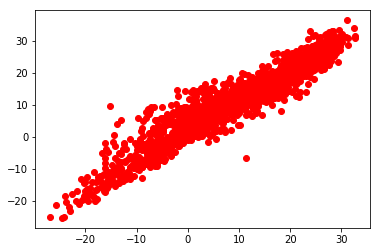

In [14]:
plt.plot([edmdict[x][ncl[0]] for x in coml],\
         [caldict[x][ncl[0]] for x in coml], 'ro')

In [26]:
def pltCalEdm(k):
    plt.figure(figsize=(8,8))
    plt.title("Edm. vs. Cal "+ncl[k])
    plt.xlabel("Edmonton")
    plt.ylabel("Calgary")
    plt.scatter([edmdict[x][ncl[k]] for x in coml],\
         [caldict[x][ncl[k]] for x in coml], alpha=0.1)
    

In [ ]:
for i in [0,1,2]:
    pltCalEdm(i)
    

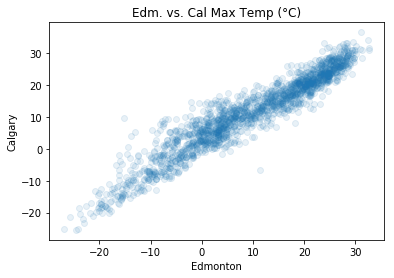

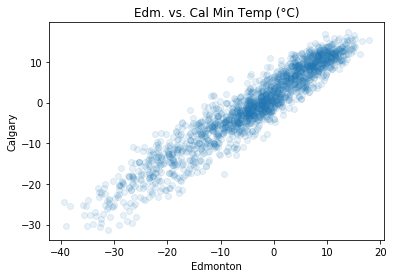

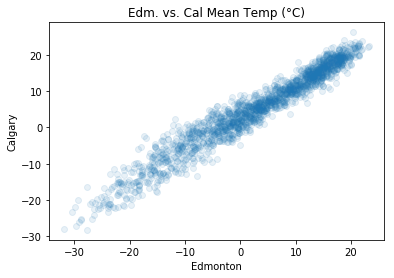

In [31]:
## i.e. the figsize call forced a new plot.
for k in [0,1,2]:
    #plt.figure(figsize=(8,8))
    plt.title("Edm. vs. Cal "+ncl[k])
    plt.xlabel("Edmonton")
    plt.ylabel("Calgary")
    plt.scatter([edmdict[x][ncl[k]] for x in coml],\
         [caldict[x][ncl[k]] for x in coml], alpha=0.1)
    #plt.show() ## this also forces the existing plot to terminate.

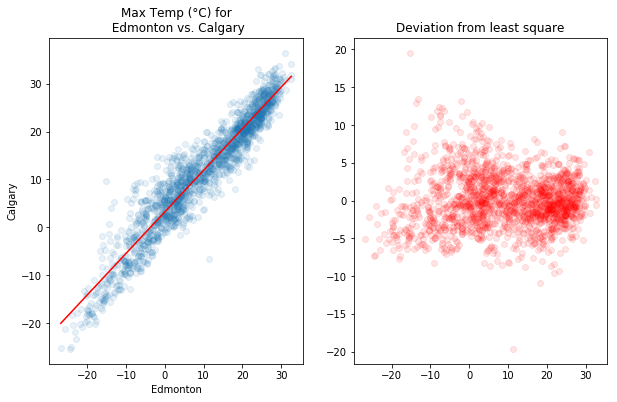

In [42]:
# subwindow.  Let's automate the above, having a subwindow with a secondary plot.
# primary plot will be as above, with a least-square fit.
# secondary plot will be the difference between least-square fcn and the data.

def pltDev(k):
    plt.figure(figsize=(10,6))

    X = [edmdict[x][ncl[k]] for x in coml]
    Y = [caldict[x][ncl[k]] for x in coml]
    
    A = np.matrix([[1.0,x] for x in X]).T
    y = np.matrix([y for y in Y]).T
    c = np.linalg.inv(A*A.T)*A*y
    
    def linlsq(x):
        return c[0,0] + c[1,0]*x

    ## subplot(a,b,c) the plot will have a rows, b columns, we edit c-th window.
    plt.subplot(1,2,1)
    plt.title(ncl[k]+" for\n Edmonton vs. Calgary")
    plt.xlabel("Edmonton")
    plt.ylabel("Calgary")

    plt.scatter(X,Y, alpha=0.1)
    plt.plot([min(X), max(X)], [linlsq(min(X)), linlsq(max(X))], 'r-')
    
    plt.subplot(1,2,2)
    plt.title("Deviation from least square")
    ## we want the deviation of the data from the least squares fit.
    plt.scatter(X, [Y[i] - linlsq(X[i]) for i in range(len(X))], color='r', alpha=0.1)
    
pltDev(0)

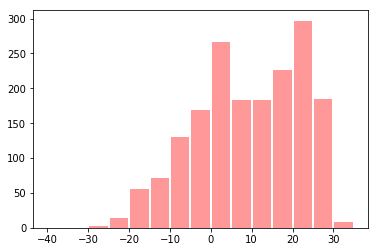

In [49]:
# Let's make a function that creates a histogram of Edmonton's weather.

## k is the argument for ncl i.e. max min mean temps
def histEdm(k):
    X = [edmdict[x][ncl[k]] for x in coml]
    plt.hist(X, bins=[-40+5*i for i in range(16)],\
             rwidth=0.9, alpha=0.4, color='r')

histEdm(0)

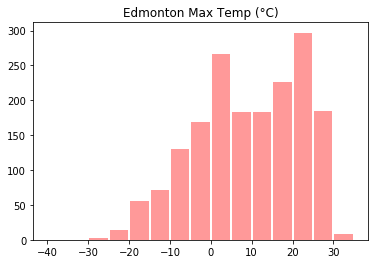

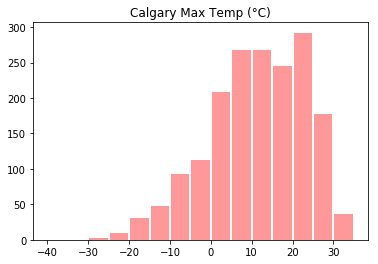

In [54]:
## make this independent of the weather dictionary. 

## k is the argument for ncl i.e. max min mean temps
def hist(D, T, k):
    X = [D[x][ncl[k]] for x in coml]
    plt.title(T+' '+ncl[k])
    plt.hist(X, bins=[-40+5*i for i in range(16)],\
             rwidth=0.9, alpha=0.4, color='r')
    plt.show()

hist(edmdict, 'Edmonton', 0)
hist(caldict, 'Calgary', 0)

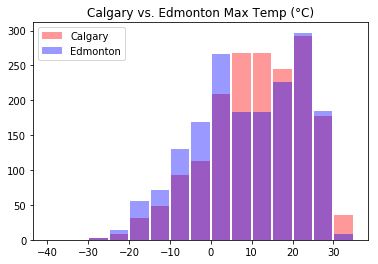

In [56]:
## let's put the two histograms on top of each other

## k is the argument for ncl i.e. max min mean temps
def hist(D1, D2, T1, T2, T, k):
    plt.title(T+' '+ncl[k])

    X = [D1[x][ncl[k]] for x in coml]
    plt.hist(X, bins=[-40+5*i for i in range(16)],\
             rwidth=0.9, alpha=0.4, color='r', label=T1)
    X = [D2[x][ncl[k]] for x in coml]
    plt.hist(X, bins=[-40+5*i for i in range(16)],\
             rwidth=0.9, alpha=0.4, color='b', label=T2)

    plt.legend()
    
    plt.show()
    
hist(caldict, edmdict, 'Calgary', 'Edmonton', 'Calgary vs. Edmonton', 0)

In [ ]:
## let's make that overlapping w/see-through bars

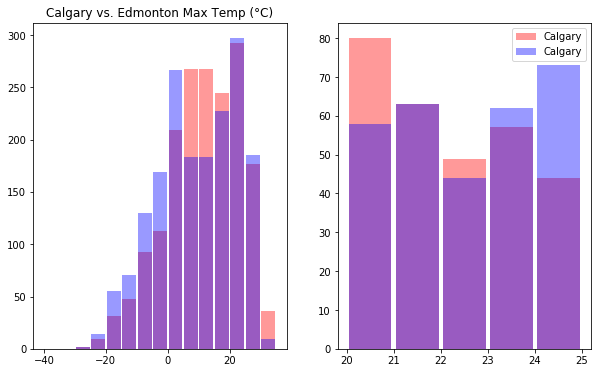

In [62]:
## And let's have a version that "zooms in" on specific bars.
## two side-by-side plots, on the left will be the previous histogram
## on the right we'll have a "zoom in" on an individual bar

## k is the argument for ncl i.e. max min mean temps
## I will be the temperature range to zoom in on 
## I will be an interval such as [20,25]
def hist(D1, D2, T1, T2, T, I, k):
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    plt.title(T+' '+ncl[k])

    X1 = [D1[x][ncl[k]] for x in coml]
    plt.hist(X1, bins=[-40+5*i for i in range(16)],\
             rwidth=0.9, alpha=0.4, color='r', label=T1)
    X2 = [D2[x][ncl[k]] for x in coml]
    plt.hist(X2, bins=[-40+5*i for i in range(16)],\
             rwidth=0.9, alpha=0.4, color='b', label=T2)

    plt.subplot(1,2,2)
    plt.hist(X1, bins=np.linspace(I[0],I[1], 6),\
             rwidth=0.9, alpha=0.4, color='r', label=T1)
    plt.hist(X2, bins=np.linspace(I[0],I[1], 6),\
             rwidth=0.9, alpha=0.4, color='b', label=T1)
    
    
    plt.legend()
    plt.show()
    
hist(caldict, edmdict, 'Calgary', 'Edmonton', 'Calgary vs. Edmonton', [20,25], 0)

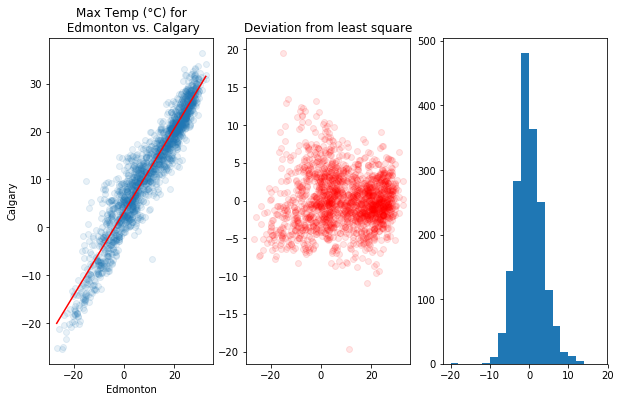

In [66]:
## Let's make a histogram of the deviation from the least squares fit.
## we will have 3 windows.  1 and 2 from the "pltDev" above. 
## the 3rd window will be a histogram of the data from 2nd plot.

def pltDevHist(k):
    plt.figure(figsize=(10,6))

    X = [edmdict[x][ncl[k]] for x in coml]
    Y = [caldict[x][ncl[k]] for x in coml]
    
    A = np.matrix([[1.0,x] for x in X]).T
    y = np.matrix([y for y in Y]).T
    c = np.linalg.inv(A*A.T)*A*y
    
    def linlsq(x):
        return c[0,0] + c[1,0]*x

    ## subplot(a,b,c) the plot will have a rows, b columns, we edit c-th window.
    plt.subplot(1,3,1)
    plt.title(ncl[k]+" for\n Edmonton vs. Calgary")
    plt.xlabel("Edmonton")
    plt.ylabel("Calgary")

    plt.scatter(X,Y, alpha=0.1)
    plt.plot([min(X), max(X)], [linlsq(min(X)), linlsq(max(X))], 'r-')
    
    plt.subplot(1,3,2)
    plt.title("Deviation from least square")
    ## we want the deviation of the data from the least squares fit.
    Yd = [Y[i] - linlsq(X[i]) for i in range(len(X))]
    plt.scatter(X, Yd, color='r', alpha=0.1)
    
    plt.subplot(1,3,3)
    plt.hist(Yd, bins=[-20+2*i for i in range(20)])
    
pltDevHist(0)

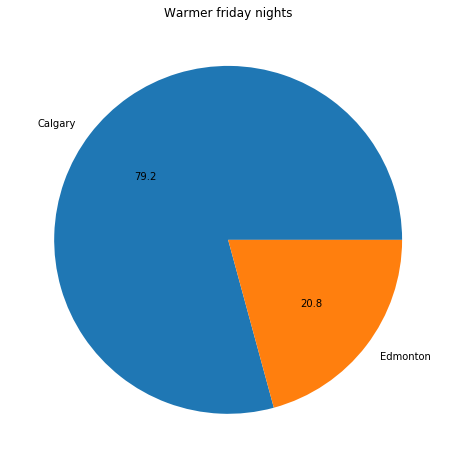

In [76]:
# Let's make a piechart.  The question is, which city has warmer Friday nights?

## we need to compute in our dates, find all the fridays
## for each such day, ask is it warmer in Edmonton or Calgary for that night?

calwins=0
edmwins=0
for x in coml:
    if x.weekday()==4:
        if caldict[x][ncl[1]] > edmdict[x][ncl[1]]:
            calwins+=1
        else:
            edmwins+=1
tot = calwins+edmwins

#with plt.xkcd():
plt.figure(figsize=(8,8))

plt.title("Warmer friday nights")
X = plt.pie([calwins/tot, edmwins/tot], labels=["Calgary", "Edmonton"], autopct='%1.1f')